<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/02_from_fid_to_se1d_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# from FID to 1D spin-echo (SE) sequence
Macroscopic field inhomogeneity is a bit annoying. We can use a refocusing RF pulse to reduce its effect and produce an echo, a.k.a. spin echo or Hahn echo:)   
**Exercise:**
1. This exercise starts from the single FID. Add a delay of a few ms between the RF and the ADC. Add a further RF event to create an echo in the ADC. Which flip angle generates the highest echo?
2.	Try to find a way so that the echo forms in the middle of the ADC. What is the general rule for the echo position in time?
3. Try to adjust RF phase offset / ADC phase offset to get (i) a real and negative echo, (ii) a real and positive echo.
4. (optional) Add more refocusing RF pulses and ADCs to retrieve the spin echo in every ADC. What is the numerical value of the decay rate of the echo peak? Is this T1, T2, or T2*?


In [5]:
#@title 1D SE in a pixel phantom - environment setup
!pip show pypulseq || pip install pypulseq &> /dev/null
#!pip install git+https://github.com/imr-framework/pypulseq.git
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

Name: pypulseq
Version: 1.4.0
Summary: Pulseq in Python
Home-page: https://github.com/imr-framework/pypulseq
Author: Keerthi Sravan Ravi
Author-email: ks3621@columbia.edu
License: License :: OSI Approved :: GNU Affero General Public License v3
Location: /usr/local/lib/python3.10/dist-packages
Requires: coverage, matplotlib, numpy, scipy, sigpy
Required-by: MRzeroCore
Name: MRzeroCore
Version: 0.2.9
Summary: Core functionality of MRzero
Home-page: 
Author: 
Author-email: Jonathan Endres <jonathan.endres@uk-erlangen.de>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, pydisseqt, pypulseq, requests, scikit-image, scipy, torch, torchkbnufft
Required-by: 


In [6]:
#@title 1D SE in a pixel phantom - sequence
# %% DEFINE the sequence, FOV and resolution
seq=mr.Sequence()
Nread=256
Nrep=10 # repeat the fid sequence mutiple times
TE=6e-3

experiment_id = 'se'
# %% SETUP system
# choose the scanner limits
system = mr.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6)

# Define rf event
# hard pulse for excitation
rf_ex = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)
rf_ref = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)

# Define ADC event
adc = mr.make_adc(num_samples=Nread, duration=51.2e-3, phase_offset=180*np.pi/180, delay=0e-3, system=system)
TE = 2*(adc.dwell*adc.num_samples/2+rf_ref.ringdown_time+rf_ref.shape_dur/2) # for echo in the middle of ADC

# Calcualte timing
delayTE1 = TE/2-rf_ex.shape_dur/2-rf_ex.ringdown_time-rf_ref.delay-rf_ref.shape_dur/2
delayTE2 = TE/2-rf_ref.shape_dur/2-rf_ref.ringdown_time-adc.delay-adc.dwell*adc.num_samples/2

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf_ex)
seq.add_block(mr.make_delay(delayTE1))
for i in range(Nrep):
  #seq.add_block(mr.make_delay(delayTE2))
  seq.add_block(rf_ref)
  seq.add_block(adc)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('Name', 'se')
seq.write('02_fid2se1d_solution.seq')

Timing check passed successfully


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


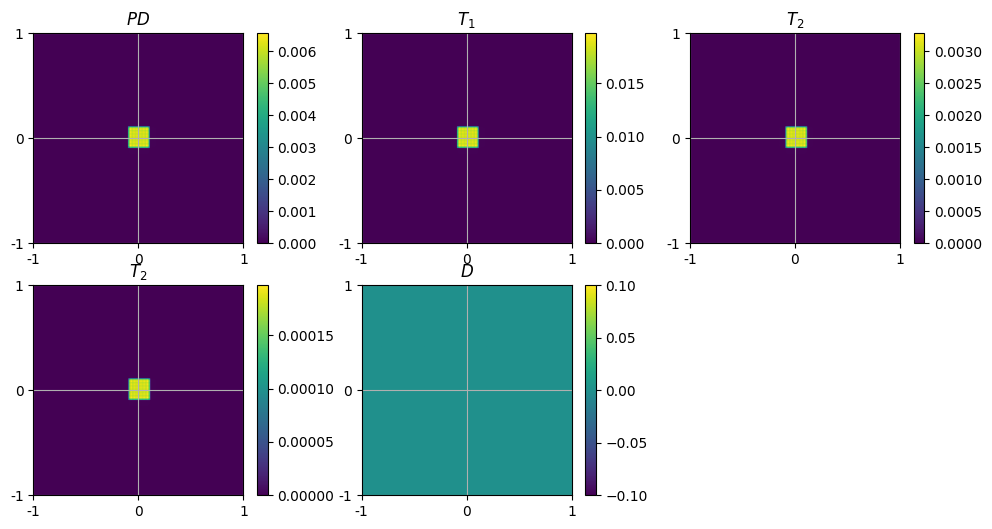

Some sections were ignored: ['SIGNATURE']


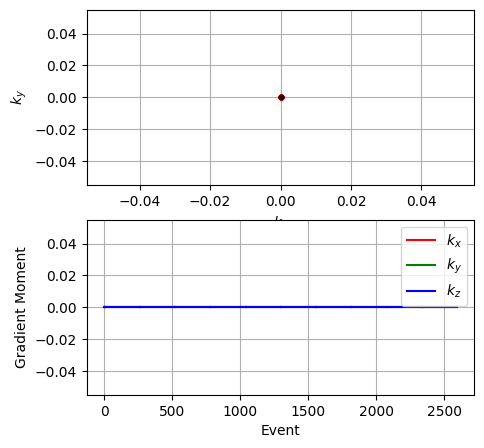

Calculating repetition 11 / 11 - done


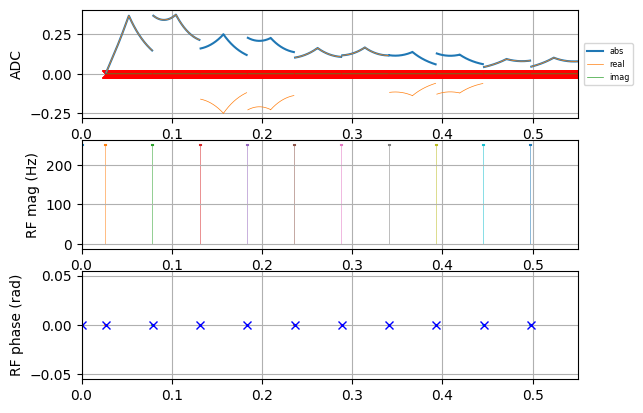

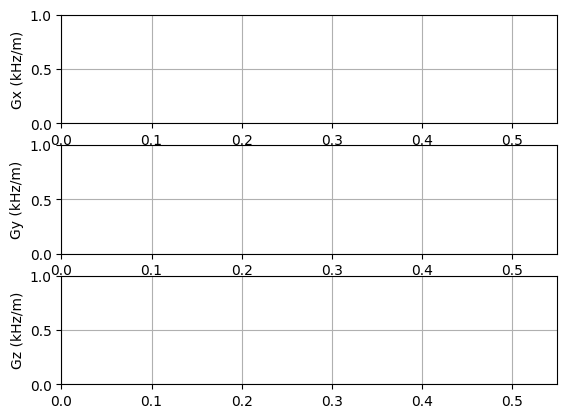

In [7]:
#@title 1D SE in a pixel phantom - simulation
dB0 = 0
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0., 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.from_seq_file("02_fid2se1d_solution.seq")
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p)
# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq,signal=signal.numpy())

In [8]:
#@title 1D SE in a pixel phantom - reconstruction
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
if Nrep==1:
  plt.figure()
  plt.title('ADC signal')
  # time axis
  time_axis=np.linspace(1, Nread, Nread)*adc.dwell ;
  plt.plot(time_axis, np.real(signal), label='real')
  plt.plot(time_axis, np.imag(signal), label='imag')
  plt.plot(time_axis, np.abs(signal), label='abs')
  plt.grid()
  plt.legend(loc="upper right")
  plt.xlabel('time (ADC)/s')
  plt.ylabel('Amplitude')

  # FFT reconstruction
  spectrum = fft_1d(signal)

  # frequency axis
  freq_axis = np.linspace(-Nread/2, Nread/2-1, Nread)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

  plt.figure()
  plt.title('spectrum')
  plt.plot(freq_axis, np.abs(spectrum))
  plt.xlabel('Frequency/Hz')
  plt.ylabel('Amplitude')